## Setup and Imports

First, let's import the necessary modules and set up our environment.

In [1]:
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
from pathlib import Path
import pandas as pd
import seaborn as sns
from typing import Dict, List, Tuple, Any

# Add project root to path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
    
# Import our modules
from src.gpt_from_scratch.trainer.trainer import ModelTrainer
from src.gpt_from_scratch.classic_ngram.classic_ngram import NGramLM, read_lines, build_stream
from src.gpt_from_scratch.mini_gpt.mini_gpt import MiniGPT
from src.gpt_from_scratch.tokenizer.tokenizer_bpe import BPETokenizer
from src.gpt_from_scratch.neural_ngram.neural_ngram import NeuralNGramModel

# CHOOSE YOUR DEVICE - pick ONE of these options:

# # Option 1: Force CPU (safe but slower)
# os.environ["DEVICE"] = "cpu"
# device = torch.device("cpu")
# print(f"Using device: {device}")

# Option 2: Use MPS if available (faster but might have issues)
os.environ["DEVICE"] = "mps"
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print(f"Using MPS device: {device}")
else:
    device = torch.device("cpu")
    print(f"MPS not available, using: {device}")

# Disable torch compile to avoid MPS compatibility issues
torch._dynamo.config.disable = True

Using MPS device: mps


## Data Loading

Let's load and prepare the data for our models.

In [2]:
# define paths
DATA_DIR = project_root / "data/processed"
TRAIN_PATH = DATA_DIR / "train.txt"
VAL_PATH = DATA_DIR / "val.txt"
TOKENIZER_DIR = project_root / "tokenizers"

# create directories if they don't exist
DATA_DIR.mkdir(exist_ok=True, parents=True)
TOKENIZER_DIR.mkdir(exist_ok=True, parents=True)

# check if data exists, otherwise download/create sample data
if not TRAIN_PATH.exists() or not VAL_PATH.exists():
    print("Data files not found. Creating sample data...")
    
    # create simple sample data for demonstration
    sample_text = """
    The quick brown fox jumps over the lazy dog. 
    To be or not to be, that is the question.
    All that glitters is not gold.
    Actions speak louder than words.
    A picture is worth a thousand words.
    """
    
    # split into train/val
    lines = [line.strip() for line in sample_text.strip().split('\n') if line.strip()]
    train_lines = lines[:int(len(lines) * 0.8)]
    val_lines = lines[int(len(lines) * 0.8):]
    
    # write to files
    DATA_DIR.mkdir(exist_ok=True, parents=True)
    with open(TRAIN_PATH, 'w') as f:
        f.write('\n'.join(train_lines))
    with open(VAL_PATH, 'w') as f:
        f.write('\n'.join(val_lines))
    
    print(f"Created sample data at {TRAIN_PATH} and {VAL_PATH}")

# load the data
train_lines = read_lines(TRAIN_PATH)
val_lines = read_lines(VAL_PATH)

print(f"Loaded {len(train_lines)} training lines and {len(val_lines)} validation lines")

Loaded 1 training lines and 1 validation lines


## Tokenizer Setup

Train a BPE tokenizer on our data.

In [3]:
def train_tokenizer(merges: int = 200):
    """Train a BPE tokenizer on the training data."""
    tokenizer = BPETokenizer(
        seed=42,
        bos_token="<BOS>",
        eos_token="<EOS>",
        pad_token=None,
        unk_token=None,
        lowercase=True,
        unicode_normalization="NFKC",
        collapse_whitespace=True,
        keep_newlines=True,
    )
    
    # train on training data
    train_text = TRAIN_PATH.read_text(encoding="utf-8")
    tokenizer.train(
        train_text,
        merges=merges,
        guard_train_only=True,
        source_tag="train",
        min_pair_freq=1,
    )
    
    # save tokenizer
    tag = f"bpe_{merges:04d}"
    tokenizer.save(str(TOKENIZER_DIR), tag)
    
    print(f"Trained tokenizer with {merges} merges. Vocabulary size: {len(tokenizer.vocab)}")
    return tokenizer


#----------more extended training-------
# Train the tokenizer
tokenizer = train_tokenizer(merges=200)

# for longer experiment
merge_values = [200, 500, 1000]
#--------------------------------------

#-------- for fastest experiment------------
#merge_values = [200]
#---------------------------------------

tokenizers = {}

for merges in merge_values:
    print(f"\n=== Training tokenizer with {merges} merges ===")
    tokenizers[merges] = train_tokenizer(merges=merges)
    
print(f"\nTrained {len(tokenizers)} tokenizers with merge counts: {list(tokenizers.keys())}")

tokenizer = tokenizers[200]

# test the tokenizer
sample_text = "The quick brown fox jumps over the lazy dog."
encoded = tokenizer.encode(sample_text, add_bos=True, add_eos=True)
decoded = tokenizer.decode(encoded)

print(f"\nOriginal: {sample_text}")
print(f"Encoded: {encoded}")
print(f"Decoded: {decoded}")
print(f"Tokenized: {[tokenizer.decode([t]) for t in encoded]}")

Trained tokenizer with 200 merges. Vocabulary size: 458

=== Training tokenizer with 200 merges ===
Trained tokenizer with 200 merges. Vocabulary size: 458

=== Training tokenizer with 500 merges ===
Trained tokenizer with 500 merges. Vocabulary size: 758

=== Training tokenizer with 1000 merges ===
Trained tokenizer with 1000 merges. Vocabulary size: 1258

Trained 3 tokenizers with merge counts: [200, 500, 1000]

Original: The quick brown fox jumps over the lazy dog.
Encoded: [0, 297, 417, 107, 378, 295, 116, 425, 322, 113, 122, 34, 108, 119, 111, 114, 263, 113, 366, 298, 325, 124, 269, 102, 113, 105, 48, 1]
Decoded: the quick brown fox jumps over the lazy dog.
Tokenized: ['', 'the ', 'qu', 'i', 'ck', ' b', 'r', 'own', ' f', 'o', 'x', ' ', 'j', 'u', 'm', 'p', 's ', 'o', 'ver', ' the ', 'la', 'z', 'y ', 'd', 'o', 'g', '.', '']


## Prepare Data for Models

Convert text data to token streams for both model types.

In [4]:
# process data for n-gram models
train_stream = build_stream(tokenizer, train_lines)
val_stream = build_stream(tokenizer, val_lines)

print(f"Train stream length: {len(train_stream)} tokens")
print(f"Val stream length: {len(val_stream)} tokens")

# create tensor datasets for neural models
def create_tensor_dataset(token_stream, context_size=64):
    data = torch.tensor(token_stream, dtype=torch.long)
    
    # create sequences of context_size + 1
    sequences = []
    for i in range(0, len(data) - context_size):
        seq = data[i:i+context_size+1]
        sequences.append(seq)
    
    if sequences:
        # stack sequences into a tensor
        tensor_data = torch.stack(sequences)
        
        # split into inputs and targets
        x = tensor_data[:, :-1]  # all but last token
        y = tensor_data[:, 1:]   # all but first token
        
        return x, y
    else:
        # handle case with too short data
        print("Warning: Data too short to create sequences!")
        return torch.tensor([], dtype=torch.long), torch.tensor([], dtype=torch.long)

# create tensor data for neural models
context_size = 64  # Context window size
x_train, y_train = create_tensor_dataset(train_stream, context_size)
x_val, y_val = create_tensor_dataset(val_stream, context_size)

print(f"\nNeural model train input shape: {x_train.shape if len(x_train) > 0 else 'Empty'}")
print(f"Neural model val input shape: {x_val.shape if len(x_val) > 0 else 'Empty'}")

Train stream length: 1999874 tokens
Val stream length: 243767 tokens

Neural model train input shape: torch.Size([1999810, 64])
Neural model val input shape: torch.Size([243703, 64])


## Training Configuration

Define configurations for both model types.

In [5]:
#---------For faster experiment----------------

ngram_configs = [
    {"n": 1, "delta": 0.1, "smoothing": "laplace", "epochs": 10, "learning_rate": 0.01, "batch_size": 32, "context_size": context_size},
    {"n": 2, "delta": 0.1, "smoothing": "laplace", "epochs": 10, "learning_rate": 0.01, "batch_size": 32, "context_size": context_size},
    {"n": 3, "delta": 0.1, "smoothing": "laplace", "epochs": 10, "learning_rate": 0.01, "batch_size": 32, "context_size": context_size},
    {"n": 2, "delta": 0.1, "smoothing": "backoff", "epochs": 10, "learning_rate": 0.01, "batch_size": 32, "context_size": context_size},
    {"n": 3, "delta": 0.1, "smoothing": "interpolation", "epochs": 10, "learning_rate": 0.01, "batch_size": 32, "context_size": context_size}
]

# keep only one GPT model
gpt_configs = [
    {
        "name": "tiny",
        "vocab_size": len(tokenizer.vocab),
        "n_embd": 64,
        "n_head": 4,
        "n_layer": 4,
        "context_size": context_size,
        "epochs": 10,
        "learning_rate": 3e-4,
        "batch_size": 32,
    }
    # remove the "small" configuration
]

# keep only one Neural N-Gram model
neural_ngram_configs = [
    {
        "name": "neural_bigram",
        "vocab_size": len(tokenizer.vocab),
        "context_size": 2,
        "embedding_dim": 64,
        "hidden_dim": 128,
        "epochs": 10,
        "learning_rate": 3e-4,
        "batch_size": 32,
    }
    # remove the "neural_trigram" configuration
]

#---------For bigger experiment----------------
# # N-gram configurations
# ngram_configs = [
#     {"n": 1, "delta": 0.1, "smoothing": "laplace", "epochs": 1, "learning_rate": 0.01, "batch_size": 32, "context_size": context_size},
#     {"n": 2, "delta": 0.1, "smoothing": "laplace", "epochs": 1, "learning_rate": 0.01, "batch_size": 32, "context_size": context_size},
#     {"n": 3, "delta": 0.1, "smoothing": "laplace", "epochs": 1, "learning_rate": 0.01, "batch_size": 32, "context_size": context_size},
#     {"n": 2, "delta": 0.1, "smoothing": "backoff", "epochs": 1, "learning_rate": 0.01, "batch_size": 32, "context_size": context_size},
#     {"n": 3, "delta": 0.1, "smoothing": "interpolation", "epochs": 1, "learning_rate": 0.01, "batch_size": 32, "context_size": context_size}
# ]

# # Mini-GPT configurations
# gpt_configs = [
#     {
#         "name": "tiny",
#         "vocab_size": len(tokenizer.vocab),
#         "n_embd": 64,
#         "n_head": 4,
#         "n_layer": 4,
#         "context_size": context_size,
#         "epochs": 1,
#         "learning_rate": 3e-4,
#         "batch_size": 32,
#     },
#     {
#         "name": "small",
#         "vocab_size": len(tokenizer.vocab),
#         "n_embd": 128,
#         "n_head": 8,
#         "n_layer": 6,
#         "context_size": context_size,
#         "epochs": 1,
#         "learning_rate": 3e-4,
#         "batch_size": 32,
#     }
# ]

# # Neural N-Gram configurations
# neural_ngram_configs = [
#     {
#         "name": "neural_bigram",
#         "vocab_size": len(tokenizer.vocab),
#         "context_size": 2,  # For a bigram model
#         "embedding_dim": 64,
#         "hidden_dim": 128,
#         "epochs": 1,
#         "learning_rate": 3e-4,
#         "batch_size": 32,
#     },
#     {
#         "name": "neural_trigram",
#         "vocab_size": len(tokenizer.vocab),
#         "context_size": 3,  # For a trigram model
#         "embedding_dim": 128,
#         "hidden_dim": 256,
#         "epochs": 1,
#         "learning_rate": 3e-4,
#         "batch_size": 32,
#     }
# ]
#-----------------------------------------------------------------
def update_vocab_sizes(configs_list, vocab_size):
    """Create copies of configs with updated vocab size."""
    updated_configs = []
    for config in configs_list:
        new_config = config.copy()  # Create a copy
        new_config['vocab_size'] = vocab_size  # Update the copy
        updated_configs.append(new_config)
    return updated_configs

In [6]:
def run_ngram_experiments(tokenizer, train_stream, val_stream, ngram_configs):
    """Run N-gram experiments with given tokenizer."""
    results = []
    
    for config in ngram_configs:
        print(f"\nTraining N-gram model with n={config['n']}, smoothing={config['smoothing']}...")
        start_time = time.time()
        
        # create the model
        model = NGramLM(
            n=config['n'], 
            delta=config['delta'], 
            vocab_size=len(tokenizer.vocab),
            smoothing_method=config['smoothing']
        )
        
        # use the trainer for n-gram models
        trainer_config = {
            'epochs': config['epochs'],
            'learning_rate': config['learning_rate'],
            'batch_size': config['batch_size'],
            'use_mixed_precision': False, 
            'context_size': config['context_size']
        }
            
        experiment_dir = Path(f"../experiments/ngram_{config['n']}_{config['smoothing']}")
        experiment_dir.mkdir(parents=True, exist_ok=True)
        
        trainer = ModelTrainer(
            model_type="ngram",
            config=trainer_config,
            experiment_dir=experiment_dir
        )
        
        # train using the trainer
        model, metrics = trainer.train(model, train_stream, val_stream)
        train_time = time.time() - start_time
        
        # evaluate the model
        train_ppl = model.perplexity(train_stream)
        val_ppl = model.perplexity(val_stream)
        
        # generate a sample
        seed_text = "The"
        prefix = tokenizer.encode(seed_text, add_bos=False, add_eos=False)
        generated_ids = model.generate_text(
            prefix=prefix,
            max_length=30,
            temperature=0.8,
            eos_token=tokenizer.inverse_vocab["<EOS>"]
        )
        try:
            generated_text = tokenizer.decode(generated_ids)
        except UnicodeDecodeError:
            generated_text = f"<Unicode decode error: invalid byte sequence in generated tokens>"
        
        # store results
        result = {
            "type": "N-gram",
            "config": f"{config['n']}-gram ({config['smoothing']})",
            "train_time": train_time,
            "train_ppl": train_ppl,
            "val_ppl": val_ppl,
            "sample": generated_text
        }
        results.append(result)
        
        print(f"  Training time: {train_time:.2f}s")
        print(f"  Train perplexity: {train_ppl:.2f}")
        print(f"  Val perplexity: {val_ppl:.2f}")
        print(f"  Generated text: '{generated_text}'")
    
    return results

def run_neural_ngram_experiments(tokenizer, x_train, y_train, x_val, y_val, neural_ngram_configs):
    """Run Neural N-gram experiments with given tokenizer."""
    results = []
    
    for config in neural_ngram_configs:
        print(f"\nTraining Neural N-Gram model: {config['name']}...")
        
        # initialize model
        model = NeuralNGramModel(
            vocab_size=config['vocab_size'],
            context_size=config['context_size'],
            embedding_dim=config['embedding_dim'],
            hidden_dim=config['hidden_dim'],
            dropout=0.1
        )
        
        model = model.to(device)

        # setup trainer
        trainer_config = {
            'epochs': config['epochs'],
            'learning_rate': config['learning_rate'],
            'batch_size': config['batch_size'],
            'use_mixed_precision': False,
            'context_size': config['context_size']
        }
        
        experiment_dir = Path(f"../experiments/neural_ngram_{config['name']}")
        experiment_dir.mkdir(parents=True, exist_ok=True)
        
        trainer = ModelTrainer(
            model_type="neural",
            config=trainer_config,
            experiment_dir=experiment_dir
        )
        
        # prepare data
        from torch.utils.data import TensorDataset, DataLoader
        
        def prepare_ngram_data(x, y, context_size):
            if x.size(1) > context_size:
                inputs = x[:, -context_size:]
            else:
                inputs = x
            targets = y[:, -1]
            return TensorDataset(inputs, targets)
        
        train_dataset = prepare_ngram_data(x_train, y_train, config['context_size'])
        val_dataset = prepare_ngram_data(x_val, y_val, config['context_size'])
        
        train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=config['batch_size'])
        
        # train model
        start_time = time.time()
        model, metrics = trainer.train(model, train_loader, val_loader)
        train_time = time.time() - start_time
        
        # get final metrics
        final_train_metrics = metrics['train_metrics'][-1] if metrics['train_metrics'] else {'loss': float('nan')}
        final_val_metrics = metrics['val_metrics'][-1] if metrics['val_metrics'] else {'loss': float('nan'), 'perplexity': float('nan')}
        
        # generate sample
        try:
            model.eval()
            prefix = tokenizer.encode("The", add_bos=False, add_eos=False)
            
            if len(prefix) >= model.context_size:
                input_tokens = prefix[-model.context_size:]
            else:
                padding_needed = model.context_size - len(prefix)
                input_tokens = [0] * padding_needed + prefix
            
            input_ids = torch.tensor([input_tokens], dtype=torch.long).to(next(model.parameters()).device)
            generated_ids = model.generate(input_ids, max_new_tokens=30, temperature=0.8, top_k=50)
            sample = tokenizer.decode(generated_ids[0].tolist())
        except Exception as e:
            sample = f"<Generation failed: {str(e)}>"
        
        # store results
        result = {
            "type": "Neural N-Gram",
            "config": f"{config['name']} (ctx={config['context_size']}, emb={config['embedding_dim']})",
            "train_time": train_time,
            "train_ppl": torch.exp(torch.tensor(final_train_metrics['loss'])).item(),
            "val_ppl": final_val_metrics['perplexity'],
            "sample": sample
        }
        results.append(result)
        
        print(f"  Training time: {train_time:.2f}s")
        print(f"  Train perplexity: {torch.exp(torch.tensor(final_train_metrics['loss'])).item():.2f}")
        print(f"  Val perplexity: {final_val_metrics['perplexity']:.2f}")
        print(f"  Generated text: '{sample}'")
    
    return results

def run_gpt_experiments(tokenizer, x_train, y_train, x_val, y_val, gpt_configs):
    """Run Mini-GPT experiments with given tokenizer."""
    results = []
    
    for config in gpt_configs:
        print(f"\nTraining Mini-GPT model: {config['name']}...")
        
        # initialize model
        model = MiniGPT(
            vocab_size=config['vocab_size'],
            embedding_dim=config['n_embd'],  
            context_size=config['context_size'],
            n_layers=config['n_layer'],      
            n_heads=config['n_head'],        
            dropout=0.1
        )
        
        model = model.to(device)

        # setup trainer
        trainer_config = {
            'epochs': config['epochs'],
            'learning_rate': config['learning_rate'],
            'batch_size': config['batch_size'],
            'use_mixed_precision': True,
            'context_size': config['context_size']
        }
        
        experiment_dir = Path(f"../experiments/mini_gpt_{config['name']}")
        experiment_dir.mkdir(parents=True, exist_ok=True)
        
        trainer = ModelTrainer(
            model_type="neural",
            config=trainer_config,
            experiment_dir=experiment_dir
        )
        
        # create datasets
        from torch.utils.data import TensorDataset, DataLoader
        train_dataset = TensorDataset(x_train, y_train)
        val_dataset = TensorDataset(x_val, y_val)
        
        train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=config['batch_size'])
        
        # train model
        start_time = time.time()
        model, metrics = trainer.train(model, train_loader, val_loader)
        train_time = time.time() - start_time
        
        # get final metrics
        final_train_metrics = metrics['train_metrics'][-1] if metrics['train_metrics'] else {'loss': float('nan')}
        final_val_metrics = metrics['val_metrics'][-1] if metrics['val_metrics'] else {'loss': float('nan'), 'perplexity': float('nan')}
        
        # generate sample
        try:
            model.eval()
            prefix = tokenizer.encode("The", add_bos=False, add_eos=False)
            input_ids = torch.tensor([prefix], dtype=torch.long).to(next(model.parameters()).device)
            
            if hasattr(model, 'generate'):
                generated_ids = model.generate(input_ids, max_new_tokens=30, temperature=0.8, top_k=50)
                sample = tokenizer.decode(generated_ids[0].tolist())
            else:
                # fallback generation
                with torch.no_grad():
                    for _ in range(30):
                        outputs = model(input_ids)
                        next_token_logits = outputs[:, -1, :]
                        probs = torch.nn.functional.softmax(next_token_logits / 0.8, dim=-1)
                        next_token = torch.multinomial(probs, num_samples=1)
                        input_ids = torch.cat([input_ids, next_token], dim=1)
                        
                        if hasattr(tokenizer, 'eos_id') and next_token.item() == tokenizer.eos_id:
                            break
                            
                sample = tokenizer.decode(input_ids[0].tolist())
        except Exception as e:
            sample = f"<Generation failed: {str(e)}>"
        
        # store results
        result = {
            "type": "Mini-GPT",
            "config": f"{config['name']} (emb={config['n_embd']}, layers={config['n_layer']})",
            "train_time": train_time,
            "train_ppl": torch.exp(torch.tensor(final_train_metrics['loss'])).item(),
            "val_ppl": final_val_metrics['perplexity'],
            "sample": sample
        }
        results.append(result)
        
        print(f"  Training time: {train_time:.2f}s")
        print(f"  Train perplexity: {torch.exp(torch.tensor(final_train_metrics['loss'])).item():.2f}")
        print(f"  Val perplexity: {final_val_metrics['perplexity']:.2f}")
        print(f"  Generated text: '{sample}'")
    
    return results

# Helper Functions for Multi-Tokenizer Experiments

In [7]:
## Stage 1: Find Best Tokenizers for N-Gram Models

print("="*60)
print("STAGE 1: TESTING ALL TOKENIZERS ON N-GRAM MODELS")
print("="*60)

# Stage 1: Test all tokenizers on N-gram models only
ngram_tokenizer_results = []
tokenizer_performance = {}

for merges, tokenizer in tokenizers.items():
    print(f"\n--- Testing {merges}-merge tokenizer on N-gram models ---")
    print(f"Vocabulary size: {len(tokenizer.vocab)}")
    
    # prepare data for this tokenizer
    train_stream = build_stream(tokenizer, train_lines)
    val_stream = build_stream(tokenizer, val_lines)
    
    # update n-gram configs with new vocab size
    current_ngram_configs = update_vocab_sizes(ngram_configs, len(tokenizer.vocab))
    
    # run N-gram experiments only
    ngram_results = run_ngram_experiments(tokenizer, train_stream, val_stream, current_ngram_configs)

    # add tokenizer info to results
    for result in ngram_results:
        result['tokenizer_merges'] = merges
        result['vocab_size'] = len(tokenizer.vocab)
    
    # store results
    ngram_tokenizer_results.extend(ngram_results)
    
    # calculate average validation perplexity for this tokenizer
    avg_val_ppl = sum([r['val_ppl'] for r in ngram_results]) / len(ngram_results)
    tokenizer_performance[merges] = {
        'avg_val_ppl': avg_val_ppl,
        'vocab_size': len(tokenizer.vocab),
        'results': ngram_results
    }
    
    print(f"Average validation perplexity for {merges}-merge tokenizer: {avg_val_ppl:.2f}")

# find top 3 tokenizers based on N-gram performance
print(f"\n{'='*60}")
print("FINDING TOP-3 TOKENIZERS FOR N-GRAM MODELS")
print(f"{'='*60}")

# sort tokenizers by average validation perplexity (lower is better)
sorted_tokenizers = sorted(tokenizer_performance.items(), 
                          key=lambda x: x[1]['avg_val_ppl'])

top_3_merges = [merges for merges, _ in sorted_tokenizers[:3]]
print("Tokenizer performance ranking (by avg validation perplexity):")
for i, (merges, perf) in enumerate(sorted_tokenizers, 1):
    marker = "top" if merges in top_3_merges else "  "
    print(f"{marker} {i}. {merges} merges (vocab={perf['vocab_size']}): {perf['avg_val_ppl']:.2f}")

print(f"\nTop-3 tokenizers selected for GPT testing: {top_3_merges}")

# create DataFrame for N-gram stage results
ngram_stage_df = pd.DataFrame(ngram_tokenizer_results)
print(f"\nStage 1 completed: {len(ngram_stage_df)} N-gram experiments")

STAGE 1: TESTING ALL TOKENIZERS ON N-GRAM MODELS

--- Testing 200-merge tokenizer on N-gram models ---
Vocabulary size: 458


2025-09-01 17:12:54,073 - INFO - Efficient attention enabled
2025-09-01 17:12:54,073 - INFO - Initialized trainer on mps
2025-09-01 17:12:54,074 - INFO - Starting training for ngram model
2025-09-01 17:12:54,074 - INFO - Training classical n-gram model...
2025-09-01 17:12:54,255 - INFO - Validation perplexity: 160.905
2025-09-01 17:12:54,256 - INFO - N-gram training completed in 0.18 seconds



Training N-gram model with n=1, smoothing=laplace...


2025-09-01 17:12:54,779 - INFO - Efficient attention enabled
2025-09-01 17:12:54,779 - INFO - Initialized trainer on mps
2025-09-01 17:12:54,779 - INFO - Starting training for ngram model
2025-09-01 17:12:54,780 - INFO - Training classical n-gram model...


  Training time: 0.19s
  Train perplexity: 160.54
  Val perplexity: 160.91
  Generated text: 'the wi&ouytheat your7e. 'x you&she 's x ofo.  seck wf this of9:qu'

Training N-gram model with n=2, smoothing=laplace...


2025-09-01 17:12:55,252 - INFO - Validation perplexity: 41.678
2025-09-01 17:12:55,253 - INFO - N-gram training completed in 0.47 seconds
2025-09-01 17:12:55,862 - INFO - Efficient attention enabled
2025-09-01 17:12:55,862 - INFO - Initialized trainer on mps
2025-09-01 17:12:55,862 - INFO - Starting training for ngram model
2025-09-01 17:12:55,863 - INFO - Training classical n-gram model...


  Training time: 0.47s
  Train perplexity: 40.76
  Val perplexity: 41.68
  Generated text: 'thee compl froud with by sterswhat ive to your hervein so sha'

Training N-gram model with n=3, smoothing=laplace...


2025-09-01 17:12:56,436 - INFO - Validation perplexity: 21.987
2025-09-01 17:12:56,436 - INFO - N-gram training completed in 0.57 seconds
2025-09-01 17:12:57,181 - INFO - Efficient attention enabled
2025-09-01 17:12:57,182 - INFO - Initialized trainer on mps
2025-09-01 17:12:57,182 - INFO - Starting training for ngram model
2025-09-01 17:12:57,182 - INFO - Training classical n-gram model...


  Training time: 0.58s
  Train perplexity: 16.81
  Val perplexity: 21.99
  Generated text: '<Unicode decode error: invalid byte sequence in generated tokens>'

Training N-gram model with n=2, smoothing=backoff...


2025-09-01 17:12:57,660 - INFO - Validation perplexity: 41.306
2025-09-01 17:12:57,660 - INFO - N-gram training completed in 0.48 seconds
2025-09-01 17:12:58,230 - INFO - Efficient attention enabled
2025-09-01 17:12:58,230 - INFO - Initialized trainer on mps
2025-09-01 17:12:58,230 - INFO - Starting training for ngram model
2025-09-01 17:12:58,231 - INFO - Training classical n-gram model...


  Training time: 0.48s
  Train perplexity: 40.57
  Val perplexity: 41.31
  Generated text: 'thee to be dition! whe) ress, we' le, and gn, and be dish'd so '

Training N-gram model with n=3, smoothing=interpolation...


2025-09-01 17:12:58,878 - INFO - Validation perplexity: 43.723
2025-09-01 17:12:58,878 - INFO - N-gram training completed in 0.65 seconds


  Training time: 0.65s
  Train perplexity: 36.04
  Val perplexity: 43.72
  Generated text: '<Unicode decode error: invalid byte sequence in generated tokens>'
Average validation perplexity for 200-merge tokenizer: 61.92

--- Testing 500-merge tokenizer on N-gram models ---
Vocabulary size: 758


2025-09-01 17:15:20,693 - INFO - Efficient attention enabled
2025-09-01 17:15:20,694 - INFO - Initialized trainer on mps
2025-09-01 17:15:20,694 - INFO - Starting training for ngram model
2025-09-01 17:15:20,694 - INFO - Training classical n-gram model...
2025-09-01 17:15:20,839 - INFO - Validation perplexity: 339.644
2025-09-01 17:15:20,839 - INFO - N-gram training completed in 0.15 seconds



Training N-gram model with n=1, smoothing=laplace...


2025-09-01 17:15:21,256 - INFO - Efficient attention enabled
2025-09-01 17:15:21,256 - INFO - Initialized trainer on mps
2025-09-01 17:15:21,256 - INFO - Starting training for ngram model
2025-09-01 17:15:21,257 - INFO - Training classical n-gram model...


  Training time: 0.15s
  Train perplexity: 337.25
  Val perplexity: 339.64
  Generated text: 'thereprothingtilogentdo resa. s earwhgood es gheboelfimake enot par py in loo?  their'

Training N-gram model with n=2, smoothing=laplace...


2025-09-01 17:15:21,642 - INFO - Validation perplexity: 63.269
2025-09-01 17:15:21,642 - INFO - N-gram training completed in 0.39 seconds
2025-09-01 17:15:22,144 - INFO - Efficient attention enabled
2025-09-01 17:15:22,144 - INFO - Initialized trainer on mps
2025-09-01 17:15:22,144 - INFO - Starting training for ngram model
2025-09-01 17:15:22,144 - INFO - Training classical n-gram model...


  Training time: 0.39s
  Train perplexity: 57.82
  Val perplexity: 63.27
  Generated text: 'thee. garning into the prince, that weland donegree wit; and now, et at dead, si'

Training N-gram model with n=3, smoothing=laplace...


2025-09-01 17:15:22,682 - INFO - Validation perplexity: 54.383
2025-09-01 17:15:22,682 - INFO - N-gram training completed in 0.54 seconds
2025-09-01 17:15:23,351 - INFO - Efficient attention enabled
2025-09-01 17:15:23,352 - INFO - Initialized trainer on mps
2025-09-01 17:15:23,352 - INFO - Starting training for ngram model
2025-09-01 17:15:23,352 - INFO - Training classical n-gram model...


  Training time: 0.54s
  Train perplexity: 27.07
  Val perplexity: 54.38
  Generated text: '<Unicode decode error: invalid byte sequence in generated tokens>'

Training N-gram model with n=2, smoothing=backoff...


2025-09-01 17:15:23,732 - INFO - Validation perplexity: 60.720
2025-09-01 17:15:23,733 - INFO - N-gram training completed in 0.38 seconds
2025-09-01 17:15:24,203 - INFO - Efficient attention enabled
2025-09-01 17:15:24,203 - INFO - Initialized trainer on mps
2025-09-01 17:15:24,203 - INFO - Starting training for ngram model
2025-09-01 17:15:24,204 - INFO - Training classical n-gram model...


  Training time: 0.39s
  Train perplexity: 56.63
  Val perplexity: 60.72
  Generated text: 'thee, he hath birst and say-gownloy; bring upon thy houd. ere is not so ill it '

Training N-gram model with n=3, smoothing=interpolation...


2025-09-01 17:15:24,809 - INFO - Validation perplexity: 75.312
2025-09-01 17:15:24,809 - INFO - N-gram training completed in 0.61 seconds


  Training time: 0.61s
  Train perplexity: 39.91
  Val perplexity: 75.31
  Generated text: '<Unicode decode error: invalid byte sequence in generated tokens>'
Average validation perplexity for 500-merge tokenizer: 118.67

--- Testing 1000-merge tokenizer on N-gram models ---
Vocabulary size: 1258


2025-09-01 17:19:42,018 - INFO - Efficient attention enabled
2025-09-01 17:19:42,020 - INFO - Initialized trainer on mps
2025-09-01 17:19:42,020 - INFO - Starting training for ngram model
2025-09-01 17:19:42,020 - INFO - Training classical n-gram model...
2025-09-01 17:19:42,142 - INFO - Validation perplexity: 587.319
2025-09-01 17:19:42,142 - INFO - N-gram training completed in 0.12 seconds



Training N-gram model with n=1, smoothing=laplace...


2025-09-01 17:19:42,505 - INFO - Efficient attention enabled
2025-09-01 17:19:42,505 - INFO - Initialized trainer on mps
2025-09-01 17:19:42,505 - INFO - Starting training for ngram model
2025-09-01 17:19:42,506 - INFO - Training classical n-gram model...


  Training time: 0.12s
  Train perplexity: 589.70
  Val perplexity: 587.32
  Generated text: 'the"pi proenterred i willess*oneek give and, trowhaemmy um desholry,  desimhave iraughed commerciese scene t. '

Training N-gram model with n=2, smoothing=laplace...


2025-09-01 17:19:42,836 - INFO - Validation perplexity: 89.842
2025-09-01 17:19:42,837 - INFO - N-gram training completed in 0.33 seconds
2025-09-01 17:19:43,249 - INFO - Efficient attention enabled
2025-09-01 17:19:43,249 - INFO - Initialized trainer on mps
2025-09-01 17:19:43,249 - INFO - Starting training for ngram model
2025-09-01 17:19:43,249 - INFO - Training classical n-gram model...


  Training time: 0.33s
  Train perplexity: 74.69
  Val perplexity: 89.84
  Generated text: 'they, even placent to extly, whiteach eld not a suish. my makes me of mee; but i will'

Training N-gram model with n=3, smoothing=laplace...


2025-09-01 17:19:43,751 - INFO - Validation perplexity: 145.950
2025-09-01 17:19:43,751 - INFO - N-gram training completed in 0.50 seconds
2025-09-01 17:19:44,353 - INFO - Efficient attention enabled
2025-09-01 17:19:44,353 - INFO - Initialized trainer on mps
2025-09-01 17:19:44,354 - INFO - Starting training for ngram model
2025-09-01 17:19:44,354 - INFO - Training classical n-gram model...


  Training time: 0.50s
  Train perplexity: 49.65
  Val perplexity: 145.95
  Generated text: 'theceshere lish man. pish! but, for my behaviours he loves him first was irksome to ex'

Training N-gram model with n=2, smoothing=backoff...


2025-09-01 17:19:44,681 - INFO - Validation perplexity: 80.375
2025-09-01 17:19:44,681 - INFO - N-gram training completed in 0.33 seconds
2025-09-01 17:19:45,091 - INFO - Efficient attention enabled
2025-09-01 17:19:45,092 - INFO - Initialized trainer on mps
2025-09-01 17:19:45,092 - INFO - Starting training for ngram model
2025-09-01 17:19:45,092 - INFO - Training classical n-gram model...


  Training time: 0.34s
  Train perplexity: 69.28
  Val perplexity: 80.37
  Generated text: 'thee, which would best the laimpets if this we heard servant. my slings. but now to thee, '

Training N-gram model with n=3, smoothing=interpolation...


2025-09-01 17:19:45,756 - INFO - Validation perplexity: 149.959
2025-09-01 17:19:45,757 - INFO - N-gram training completed in 0.66 seconds


  Training time: 0.67s
  Train perplexity: 45.83
  Val perplexity: 149.96
  Generated text: 'thehengcounby a brother, with all my heart! dare not observe your princely feet in'
Average validation perplexity for 1000-merge tokenizer: 210.69

FINDING TOP-3 TOKENIZERS FOR N-GRAM MODELS
Tokenizer performance ranking (by avg validation perplexity):
top 1. 200 merges (vocab=458): 61.92
top 2. 500 merges (vocab=758): 118.67
top 3. 1000 merges (vocab=1258): 210.69

Top-3 tokenizers selected for GPT testing: [200, 500, 1000]

Stage 1 completed: 15 N-gram experiments


# Multi-Tokenizer Experiments


In [8]:
# run experiments across all tokenizers and models
all_results = []
tokenizer_results = {}

for merges, tokenizer in tokenizers.items():
    print(f"\n{'='*60}")
    print(f"RUNNING EXPERIMENTS WITH {merges}-MERGE TOKENIZER")
    print(f"Vocabulary size: {len(tokenizer.vocab)}")
    print(f"{'='*60}")
    
    # prepare data for this tokenizer
    train_stream = build_stream(tokenizer, train_lines)
    val_stream = build_stream(tokenizer, val_lines)
    x_train, y_train = create_tensor_dataset(train_stream, context_size)
    x_val, y_val = create_tensor_dataset(val_stream, context_size)
    
    # update configs with new vocab size
    current_ngram_configs = update_vocab_sizes(ngram_configs, len(tokenizer.vocab))
    current_gpt_configs = update_vocab_sizes(gpt_configs, len(tokenizer.vocab))
    current_neural_ngram_configs = update_vocab_sizes(neural_ngram_configs, len(tokenizer.vocab))
    
    # run all model experiments
    print(f"\n--- N-Gram Models ---")
    ngram_results = run_ngram_experiments(tokenizer, train_stream, val_stream, current_ngram_configs)
    
    print(f"\n--- Neural N-Gram Models ---")
    neural_ngram_results = run_neural_ngram_experiments(tokenizer, x_train, y_train, x_val, y_val, current_neural_ngram_configs)
    
    print(f"\n--- Mini-GPT Models ---")
    gpt_results = run_gpt_experiments(tokenizer, x_train, y_train, x_val, y_val, current_gpt_configs)    
    
    # combine results for this tokenizer
    tokenizer_results[merges] = {
        'ngram': ngram_results,
        'neural_ngram': neural_ngram_results, 
        'gpt': gpt_results
    }
    
    # add tokenizer info to results
    for result in ngram_results + neural_ngram_results + gpt_results:
        result['tokenizer_merges'] = merges
        result['vocab_size'] = len(tokenizer.vocab)
    
    # add to overall results
    all_results.extend(ngram_results + neural_ngram_results + gpt_results)

# convert to DataFrame
all_results_df = pd.DataFrame(all_results)
print(f"\n{'='*60}")
print("EXPERIMENT SUMMARY")
print(f"{'='*60}")
print(f"Total experiments: {len(all_results_df)}")
print(f"Tokenizers tested: {list(tokenizers.keys())}")
print(f"Model types: {all_results_df['type'].unique()}")

# display summary table
summary_cols = ['tokenizer_merges', 'vocab_size', 'type', 'config', 'train_ppl', 'val_ppl', 'train_time']
display(all_results_df[summary_cols].head(10))


RUNNING EXPERIMENTS WITH 200-MERGE TOKENIZER
Vocabulary size: 458


2025-09-01 17:20:58,400 - INFO - Efficient attention enabled
2025-09-01 17:20:58,400 - INFO - Initialized trainer on mps
2025-09-01 17:20:58,401 - INFO - Starting training for ngram model
2025-09-01 17:20:58,401 - INFO - Training classical n-gram model...
2025-09-01 17:20:58,573 - INFO - Validation perplexity: 160.905
2025-09-01 17:20:58,573 - INFO - N-gram training completed in 0.17 seconds



--- N-Gram Models ---

Training N-gram model with n=1, smoothing=laplace...


2025-09-01 17:20:59,094 - INFO - Efficient attention enabled
2025-09-01 17:20:59,095 - INFO - Initialized trainer on mps
2025-09-01 17:20:59,095 - INFO - Starting training for ngram model
2025-09-01 17:20:59,095 - INFO - Training classical n-gram model...


  Training time: 0.17s
  Train perplexity: 160.54
  Val perplexity: 160.91
  Generated text: 'the., im phalllowillas ; and  yourit y.  youcauram my his , ce yourrot. ou5oreres'

Training N-gram model with n=2, smoothing=laplace...


2025-09-01 17:20:59,622 - INFO - Validation perplexity: 41.678
2025-09-01 17:20:59,623 - INFO - N-gram training completed in 0.53 seconds
2025-09-01 17:21:00,317 - INFO - Efficient attention enabled
2025-09-01 17:21:00,317 - INFO - Initialized trainer on mps
2025-09-01 17:21:00,317 - INFO - Starting training for ngram model
2025-09-01 17:21:00,318 - INFO - Training classical n-gram model...


  Training time: 0.53s
  Train perplexity: 40.76
  Val perplexity: 41.68
  Generated text: 'thee well aberef. acliack bes. idyer for the a so you our'

Training N-gram model with n=3, smoothing=laplace...


2025-09-01 17:21:00,903 - INFO - Validation perplexity: 21.987
2025-09-01 17:21:00,904 - INFO - N-gram training completed in 0.59 seconds
2025-09-01 17:21:01,632 - INFO - Efficient attention enabled
2025-09-01 17:21:01,632 - INFO - Initialized trainer on mps
2025-09-01 17:21:01,633 - INFO - Starting training for ngram model
2025-09-01 17:21:01,633 - INFO - Training classical n-gram model...


  Training time: 0.59s
  Train perplexity: 16.81
  Val perplexity: 21.99
  Generated text: '<Unicode decode error: invalid byte sequence in generated tokens>'

Training N-gram model with n=2, smoothing=backoff...


2025-09-01 17:21:02,103 - INFO - Validation perplexity: 41.306
2025-09-01 17:21:02,104 - INFO - N-gram training completed in 0.47 seconds
2025-09-01 17:21:02,676 - INFO - Efficient attention enabled
2025-09-01 17:21:02,676 - INFO - Initialized trainer on mps
2025-09-01 17:21:02,677 - INFO - Starting training for ngram model
2025-09-01 17:21:02,677 - INFO - Training classical n-gram model...


  Training time: 0.48s
  Train perplexity: 40.57
  Val perplexity: 41.31
  Generated text: 'thee here-wiffrom the works hapermishopaber lation in per w'

Training N-gram model with n=3, smoothing=interpolation...


2025-09-01 17:21:03,316 - INFO - Validation perplexity: 43.723
2025-09-01 17:21:03,316 - INFO - N-gram training completed in 0.64 seconds
2025-09-01 17:21:04,795 - INFO - Efficient attention enabled
2025-09-01 17:21:04,796 - INFO - Initialized trainer on mps
2025-09-01 17:21:04,796 - INFO - Starting training for neural model


  Training time: 0.64s
  Train perplexity: 36.04
  Val perplexity: 43.72
  Generated text: 'the h,ellould once killo. sir, no. i go young and other here a sea'

--- Neural N-Gram Models ---

Training Neural N-Gram model: neural_bigram...


2025-09-01 17:21:05,336 - INFO - Model compiled for better performance
2025-09-01 17:21:05,337 - INFO - Epoch 1/10
2025-09-01 17:23:42,888 - INFO - Epoch 1: train_loss=3.9128, val_loss=3.6670, val_ppl=39.13
2025-09-01 17:23:42,888 - INFO - Epoch 2/10
2025-09-01 17:26:23,524 - INFO - Epoch 2: train_loss=3.7221, val_loss=3.6196, val_ppl=37.32
2025-09-01 17:26:23,526 - INFO - Epoch 3/10
2025-09-01 17:29:02,809 - INFO - Epoch 3: train_loss=3.6986, val_loss=3.6048, val_ppl=36.77
2025-09-01 17:29:02,811 - INFO - Epoch 4/10
2025-09-01 17:31:40,279 - INFO - Epoch 4: train_loss=3.6856, val_loss=3.5946, val_ppl=36.40
2025-09-01 17:31:40,280 - INFO - Epoch 5/10
2025-09-01 17:34:19,297 - INFO - Epoch 5: train_loss=3.6762, val_loss=3.5864, val_ppl=36.10
2025-09-01 17:34:19,298 - INFO - Epoch 6/10
2025-09-01 17:36:58,031 - INFO - Epoch 6: train_loss=3.6683, val_loss=3.5817, val_ppl=35.94
2025-09-01 17:36:58,031 - INFO - Epoch 7/10
2025-09-01 17:39:48,066 - INFO - Epoch 7: train_loss=3.6633, val_loss

  Training time: 2396.38s
  Train perplexity: 38.62
  Val perplexity: 35.39
  Generated text: 'they ble to try. os, and sheth liver am give pall! how to boy'

--- Mini-GPT Models ---

Training Mini-GPT model: tiny...


2025-09-01 20:28:41,268 - INFO - Epoch 1: train_loss=3.1270, val_loss=2.8178, val_ppl=16.74
2025-09-01 20:28:41,272 - INFO - Epoch 2/10
2025-09-01 20:57:40,229 - INFO - Epoch 2: train_loss=2.8440, val_loss=2.7658, val_ppl=15.89
2025-09-01 20:57:40,231 - INFO - Epoch 3/10
2025-09-01 21:32:14,339 - INFO - Epoch 3: train_loss=2.8064, val_loss=2.7447, val_ppl=15.56
2025-09-01 21:32:14,341 - INFO - Epoch 4/10
2025-09-01 21:53:07,133 - INFO - Epoch 4: train_loss=2.7889, val_loss=2.7286, val_ppl=15.31
2025-09-01 21:53:07,136 - INFO - Epoch 5/10
2025-09-01 22:38:28,605 - INFO - Epoch 5: train_loss=2.7780, val_loss=2.7219, val_ppl=15.21
2025-09-01 22:38:28,609 - INFO - Epoch 6/10
2025-09-01 23:43:12,331 - INFO - Epoch 6: train_loss=2.7705, val_loss=2.7146, val_ppl=15.10
2025-09-01 23:43:12,333 - INFO - Epoch 7/10
2025-09-02 00:01:38,629 - INFO - Epoch 7: train_loss=2.7655, val_loss=2.7086, val_ppl=15.01
2025-09-02 00:01:38,632 - INFO - Epoch 8/10
2025-09-02 00:21:04,238 - INFO - Epoch 8: train_

  Training time: 28186.19s
  Train perplexity: 15.72
  Val perplexity: 14.88
  Generated text: 'thee with him speak with my heart. bassanio. well, my lord; but '

RUNNING EXPERIMENTS WITH 500-MERGE TOKENIZER
Vocabulary size: 758


2025-09-02 01:53:07,504 - INFO - Efficient attention enabled
2025-09-02 01:53:07,505 - INFO - Initialized trainer on mps
2025-09-02 01:53:07,505 - INFO - Starting training for ngram model
2025-09-02 01:53:07,505 - INFO - Training classical n-gram model...
2025-09-02 01:53:07,639 - INFO - Validation perplexity: 339.644
2025-09-02 01:53:07,639 - INFO - N-gram training completed in 0.13 seconds



--- N-Gram Models ---

Training N-gram model with n=1, smoothing=laplace...


2025-09-02 01:53:08,044 - INFO - Efficient attention enabled
2025-09-02 01:53:08,044 - INFO - Initialized trainer on mps
2025-09-02 01:53:08,044 - INFO - Starting training for ngram model
2025-09-02 01:53:08,045 - INFO - Training classical n-gram model...


  Training time: 0.14s
  Train perplexity: 337.25
  Val perplexity: 339.64
  Generated text: 'thewith mane?n thanroder as hat 1 manthe redy s. guestut %ence n do whiser shallgoranind s'

Training N-gram model with n=2, smoothing=laplace...


2025-09-02 01:53:08,404 - INFO - Validation perplexity: 63.269
2025-09-02 01:53:08,404 - INFO - N-gram training completed in 0.36 seconds
2025-09-02 01:53:08,892 - INFO - Efficient attention enabled
2025-09-02 01:53:08,893 - INFO - Initialized trainer on mps
2025-09-02 01:53:08,893 - INFO - Starting training for ngram model
2025-09-02 01:53:08,893 - INFO - Training classical n-gram model...


  Training time: 0.36s
  Train perplexity: 57.82
  Val perplexity: 63.27
  Generated text: 'thee, by my way ning grave mpracordree is it hath him a shating, the '

Training N-gram model with n=3, smoothing=laplace...


2025-09-02 01:53:09,499 - INFO - Validation perplexity: 54.383
2025-09-02 01:53:09,499 - INFO - N-gram training completed in 0.61 seconds
2025-09-02 01:53:10,122 - INFO - Efficient attention enabled
2025-09-02 01:53:10,122 - INFO - Initialized trainer on mps
2025-09-02 01:53:10,122 - INFO - Starting training for ngram model
2025-09-02 01:53:10,123 - INFO - Training classical n-gram model...


  Training time: 0.61s
  Train perplexity: 27.07
  Val perplexity: 54.38
  Generated text: '<Unicode decode error: invalid byte sequence in generated tokens>'

Training N-gram model with n=2, smoothing=backoff...


2025-09-02 01:53:10,479 - INFO - Validation perplexity: 60.720
2025-09-02 01:53:10,480 - INFO - N-gram training completed in 0.36 seconds
2025-09-02 01:53:10,928 - INFO - Efficient attention enabled
2025-09-02 01:53:10,929 - INFO - Initialized trainer on mps
2025-09-02 01:53:10,929 - INFO - Starting training for ngram model
2025-09-02 01:53:10,929 - INFO - Training classical n-gram model...


  Training time: 0.37s
  Train perplexity: 56.63
  Val perplexity: 60.72
  Generated text: 'thee, dst a knot best lasoughter. i am at of five, unish'azo. he '

Training N-gram model with n=3, smoothing=interpolation...


2025-09-02 01:53:11,496 - INFO - Validation perplexity: 75.312
2025-09-02 01:53:11,496 - INFO - N-gram training completed in 0.57 seconds
2025-09-02 01:53:12,694 - INFO - Efficient attention enabled
2025-09-02 01:53:12,694 - INFO - Initialized trainer on mps
2025-09-02 01:53:12,695 - INFO - Starting training for neural model
2025-09-02 01:53:12,700 - INFO - Model compiled for better performance
2025-09-02 01:53:12,700 - INFO - Epoch 1/10


  Training time: 0.57s
  Train perplexity: 39.91
  Val perplexity: 75.31
  Generated text: 'thewe such fiend vex'd at your mine. who effect gutenberg escap we '

--- Neural N-Gram Models ---

Training Neural N-Gram model: neural_bigram...


2025-09-02 01:56:57,951 - INFO - Epoch 1: train_loss=4.8629, val_loss=4.5294, val_ppl=92.70
2025-09-02 01:56:57,952 - INFO - Epoch 2/10
2025-09-02 02:00:43,248 - INFO - Epoch 2: train_loss=4.5287, val_loss=4.4267, val_ppl=83.65
2025-09-02 02:00:43,250 - INFO - Epoch 3/10
2025-09-02 02:04:28,546 - INFO - Epoch 3: train_loss=4.4721, val_loss=4.3932, val_ppl=80.90
2025-09-02 02:04:28,549 - INFO - Epoch 4/10
2025-09-02 02:08:13,872 - INFO - Epoch 4: train_loss=4.4463, val_loss=4.3774, val_ppl=79.63
2025-09-02 02:08:13,874 - INFO - Epoch 5/10
2025-09-02 02:11:28,679 - INFO - Epoch 5: train_loss=4.4319, val_loss=4.3610, val_ppl=78.34
2025-09-02 02:11:28,682 - INFO - Epoch 6/10
2025-09-02 02:14:06,966 - INFO - Epoch 6: train_loss=4.4216, val_loss=4.3518, val_ppl=77.62
2025-09-02 02:14:06,968 - INFO - Epoch 7/10
2025-09-02 02:16:48,653 - INFO - Epoch 7: train_loss=4.4164, val_loss=4.3524, val_ppl=77.66
2025-09-02 02:16:48,654 - INFO - Epoch 8/10
2025-09-02 02:19:35,970 - INFO - Epoch 8: train_

  Training time: 2011.00s
  Train perplexity: 81.82
  Val perplexity: 76.60
  Generated text: 'thee, had stright to your goshake not bused commercily. thou bregp, hol'

--- Mini-GPT Models ---

Training Mini-GPT model: tiny...


2025-09-02 02:38:20,614 - INFO - Epoch 1: train_loss=3.7852, val_loss=3.4119, val_ppl=30.32
2025-09-02 02:38:20,617 - INFO - Epoch 2/10
2025-09-02 02:51:14,561 - INFO - Epoch 2: train_loss=3.3983, val_loss=3.3338, val_ppl=28.04
2025-09-02 02:51:14,563 - INFO - Epoch 3/10
2025-09-02 03:04:27,915 - INFO - Epoch 3: train_loss=3.3481, val_loss=3.3035, val_ppl=27.21
2025-09-02 03:04:27,918 - INFO - Epoch 4/10
2025-09-02 03:17:51,959 - INFO - Epoch 4: train_loss=3.3236, val_loss=3.2941, val_ppl=26.95
2025-09-02 03:17:51,963 - INFO - Epoch 5/10
2025-09-02 03:31:19,293 - INFO - Epoch 5: train_loss=3.3094, val_loss=3.2761, val_ppl=26.47
2025-09-02 03:31:19,295 - INFO - Epoch 6/10
2025-09-02 03:44:49,429 - INFO - Epoch 6: train_loss=3.2995, val_loss=3.2688, val_ppl=26.28
2025-09-02 03:44:49,433 - INFO - Epoch 7/10
2025-09-02 03:58:25,336 - INFO - Epoch 7: train_loss=3.2917, val_loss=3.2685, val_ppl=26.27
2025-09-02 03:58:25,337 - INFO - Epoch 8/10
2025-09-02 04:11:57,051 - INFO - Epoch 8: train_

  Training time: 7940.41s
  Train perplexity: 26.46
  Val perplexity: 25.99
  Generated text: 'thee. talk sisters. pray you heaven, lady, for the courtesy- rather'

RUNNING EXPERIMENTS WITH 1000-MERGE TOKENIZER
Vocabulary size: 1258


2025-09-02 04:43:25,280 - INFO - Efficient attention enabled
2025-09-02 04:43:25,281 - INFO - Initialized trainer on mps
2025-09-02 04:43:25,281 - INFO - Starting training for ngram model
2025-09-02 04:43:25,281 - INFO - Training classical n-gram model...
2025-09-02 04:43:25,397 - INFO - Validation perplexity: 587.319
2025-09-02 04:43:25,398 - INFO - N-gram training completed in 0.12 seconds



--- N-Gram Models ---

Training N-gram model with n=1, smoothing=laplace...


2025-09-02 04:43:25,749 - INFO - Efficient attention enabled
2025-09-02 04:43:25,749 - INFO - Initialized trainer on mps
2025-09-02 04:43:25,750 - INFO - Starting training for ngram model
2025-09-02 04:43:25,751 - INFO - Training classical n-gram model...


  Training time: 0.12s
  Train perplexity: 589.70
  Val perplexity: 587.32
  Generated text: 'the tw, that 'llhvan them she  like are  thee s to orn ace.  tonighsing, i had we  say fearsay make  it  as chillove ep'

Training N-gram model with n=2, smoothing=laplace...


2025-09-02 04:43:26,074 - INFO - Validation perplexity: 89.842
2025-09-02 04:43:26,074 - INFO - N-gram training completed in 0.32 seconds
2025-09-02 04:43:26,474 - INFO - Efficient attention enabled
2025-09-02 04:43:26,474 - INFO - Initialized trainer on mps
2025-09-02 04:43:26,475 - INFO - Starting training for ngram model
2025-09-02 04:43:26,475 - INFO - Training classical n-gram model...


  Training time: 0.33s
  Train perplexity: 74.69
  Val perplexity: 89.84
  Generated text: 'the's my troil, by in throughots the spir touchsayright 1990=trialkeyes-'

Training N-gram model with n=3, smoothing=laplace...


2025-09-02 04:43:26,980 - INFO - Validation perplexity: 145.950
2025-09-02 04:43:26,980 - INFO - N-gram training completed in 0.51 seconds
2025-09-02 04:43:27,662 - INFO - Efficient attention enabled
2025-09-02 04:43:27,662 - INFO - Initialized trainer on mps
2025-09-02 04:43:27,662 - INFO - Starting training for ngram model
2025-09-02 04:43:27,662 - INFO - Training classical n-gram model...


  Training time: 0.51s
  Train perplexity: 49.65
  Val perplexity: 145.95
  Generated text: 'the canthat demand of god on. cyptista's keep my wounds him in love for my brow of b'

Training N-gram model with n=2, smoothing=backoff...


2025-09-02 04:43:27,978 - INFO - Validation perplexity: 80.375
2025-09-02 04:43:27,978 - INFO - N-gram training completed in 0.32 seconds
2025-09-02 04:43:28,378 - INFO - Efficient attention enabled
2025-09-02 04:43:28,379 - INFO - Initialized trainer on mps
2025-09-02 04:43:28,379 - INFO - Starting training for ngram model
2025-09-02 04:43:28,379 - INFO - Training classical n-gram model...


  Training time: 0.33s
  Train perplexity: 69.28
  Val perplexity: 80.37
  Generated text: 'thee, hapt have i pand; and in to n but i will not come hemy, my move; iago. that used commerci'

Training N-gram model with n=3, smoothing=interpolation...


2025-09-02 04:43:28,936 - INFO - Validation perplexity: 149.959
2025-09-02 04:43:28,936 - INFO - N-gram training completed in 0.56 seconds
2025-09-02 04:43:30,071 - INFO - Efficient attention enabled
2025-09-02 04:43:30,071 - INFO - Initialized trainer on mps
2025-09-02 04:43:30,072 - INFO - Starting training for neural model
2025-09-02 04:43:30,075 - INFO - Model compiled for better performance
2025-09-02 04:43:30,076 - INFO - Epoch 1/10


  Training time: 0.56s
  Train perplexity: 45.83
  Val perplexity: 149.96
  Generated text: '<Unicode decode error: invalid byte sequence in generated tokens>'

--- Neural N-Gram Models ---

Training Neural N-Gram model: neural_bigram...


2025-09-02 04:46:45,613 - INFO - Epoch 1: train_loss=5.7738, val_loss=5.3716, val_ppl=215.20
2025-09-02 04:46:45,615 - INFO - Epoch 2/10
2025-09-02 04:50:00,862 - INFO - Epoch 2: train_loss=5.3090, val_loss=5.1860, val_ppl=178.76
2025-09-02 04:50:00,865 - INFO - Epoch 3/10
2025-09-02 04:53:15,891 - INFO - Epoch 3: train_loss=5.2039, val_loss=5.1191, val_ppl=167.18
2025-09-02 04:53:15,894 - INFO - Epoch 4/10
2025-09-02 04:56:31,190 - INFO - Epoch 4: train_loss=5.1788, val_loss=5.1285, val_ppl=168.76
2025-09-02 04:56:31,193 - INFO - Epoch 5/10
2025-09-02 04:59:46,027 - INFO - Epoch 5: train_loss=5.1788, val_loss=5.1293, val_ppl=168.89
2025-09-02 04:59:46,029 - INFO - Epoch 6/10
2025-09-02 05:03:01,963 - INFO - Epoch 6: train_loss=5.1766, val_loss=5.1164, val_ppl=166.74
2025-09-02 05:03:01,964 - INFO - Epoch 7/10
2025-09-02 05:06:17,759 - INFO - Epoch 7: train_loss=5.1708, val_loss=5.1169, val_ppl=166.81
2025-09-02 05:06:17,760 - INFO - Epoch 8/10
2025-09-02 05:09:33,285 - INFO - Epoch 8:

  Training time: 6490.83s
  Train perplexity: 172.51
  Val perplexity: 163.73
  Generated text: 'thee, hune, hent, be bess. the teatary, the won you; holt? sat, i'

--- Mini-GPT Models ---

Training Mini-GPT model: tiny...


2025-09-02 08:44:08,197 - INFO - Epoch 1: train_loss=4.3520, val_loss=3.9053, val_ppl=49.66
2025-09-02 08:44:08,199 - INFO - Epoch 2/10
2025-09-02 08:55:22,679 - INFO - Epoch 2: train_loss=3.8533, val_loss=3.7772, val_ppl=43.69
2025-09-02 08:55:22,682 - INFO - Epoch 3/10
2025-09-02 09:07:43,655 - INFO - Epoch 3: train_loss=3.7800, val_loss=3.7440, val_ppl=42.27
2025-09-02 09:07:43,659 - INFO - Epoch 4/10
2025-09-02 09:19:22,393 - INFO - Epoch 4: train_loss=3.7491, val_loss=3.7262, val_ppl=41.52
2025-09-02 09:19:22,396 - INFO - Epoch 5/10
2025-09-02 09:30:11,261 - INFO - Epoch 5: train_loss=3.7272, val_loss=3.7068, val_ppl=40.72
2025-09-02 09:30:11,265 - INFO - Epoch 6/10
2025-09-02 09:41:30,962 - INFO - Epoch 6: train_loss=3.7120, val_loss=3.6976, val_ppl=40.35
2025-09-02 09:41:30,966 - INFO - Epoch 7/10
2025-09-02 09:53:55,387 - INFO - Epoch 7: train_loss=3.7022, val_loss=3.6897, val_ppl=40.03
2025-09-02 09:53:55,390 - INFO - Epoch 8/10
2025-09-02 10:05:10,964 - INFO - Epoch 8: train_

  Training time: 14175.65s
  Train perplexity: 39.86
  Val perplexity: 39.41
  Generated text: 'thee, my wit hath cow'd my hand, to bid thee beheld the pale home. hor. ay, my lord'

EXPERIMENT SUMMARY
Total experiments: 21
Tokenizers tested: [200, 500, 1000]
Model types: ['N-gram' 'Neural N-Gram' 'Mini-GPT']


,tokenizer_merges,vocab_size,type,config,train_ppl,val_ppl,train_time
0,200,458,N-gram,1-gram (laplace),160.537651,160.905236,0.173799
1,200,458,N-gram,2-gram (laplace),40.760349,41.677750,0.528950
2,200,458,N-gram,3-gram (laplace),16.810928,21.986874,0.587864
3,200,458,N-gram,2-gram (backoff),40.571469,41.305608,0.475568
4,200,458,N-gram,3-gram (interpolation),36.037360,43.723061,0.641193
5,200,458,Neural N-Gram,"neural_bigram (ctx=2, emb=64)",38.620495,35.385681,2396.380289
6,200,458,Mini-GPT,"tiny (emb=64, layers=4)",15.720889,14.876051,28186.194623
7,500,758,N-gram,1-gram (laplace),337.249267,339.643804,0.137435
8,500,758,N-gram,2-gram (laplace),57.820463,63.269204,0.360890
9,500,758,N-gram,3-gram (laplace),27.072567,54.382772,0.607260


# Common Method for all architectures

## Results Visualization

Compare the performance of different models.

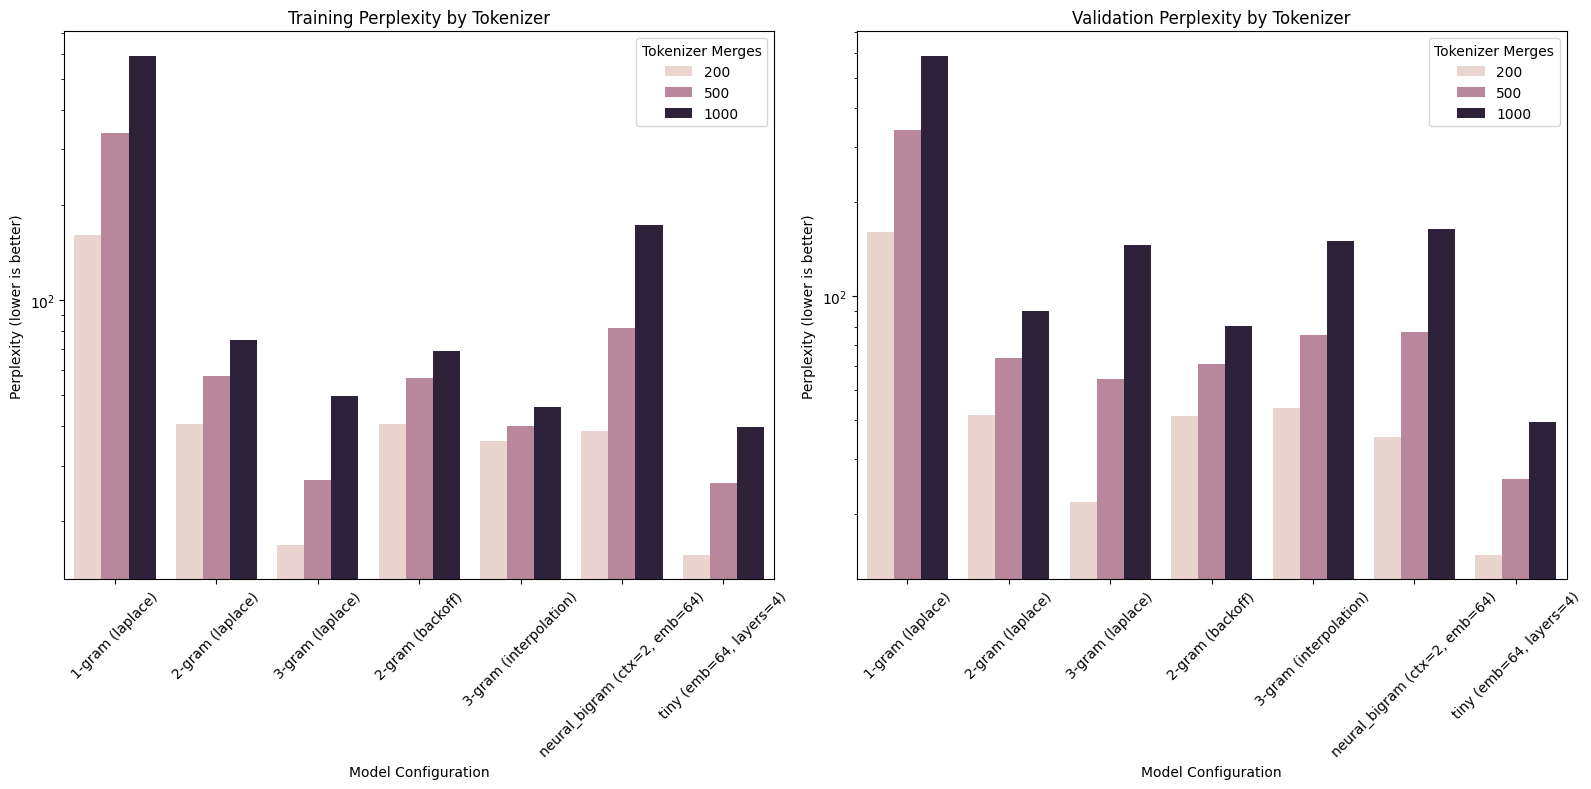

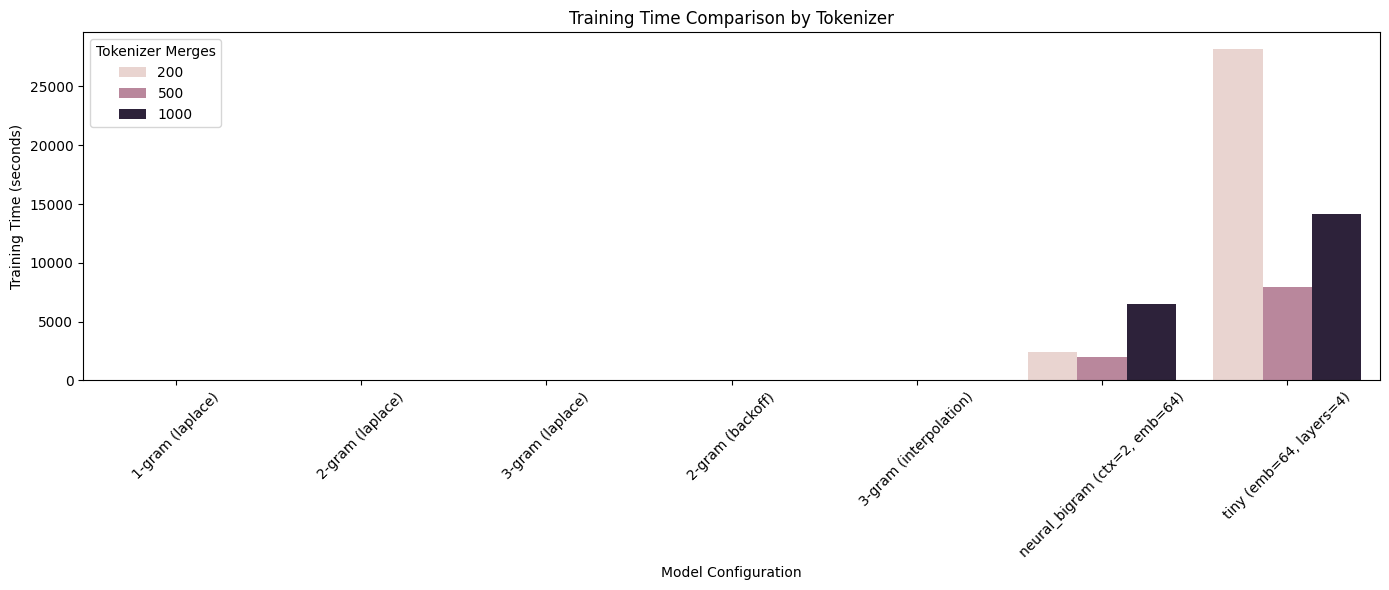

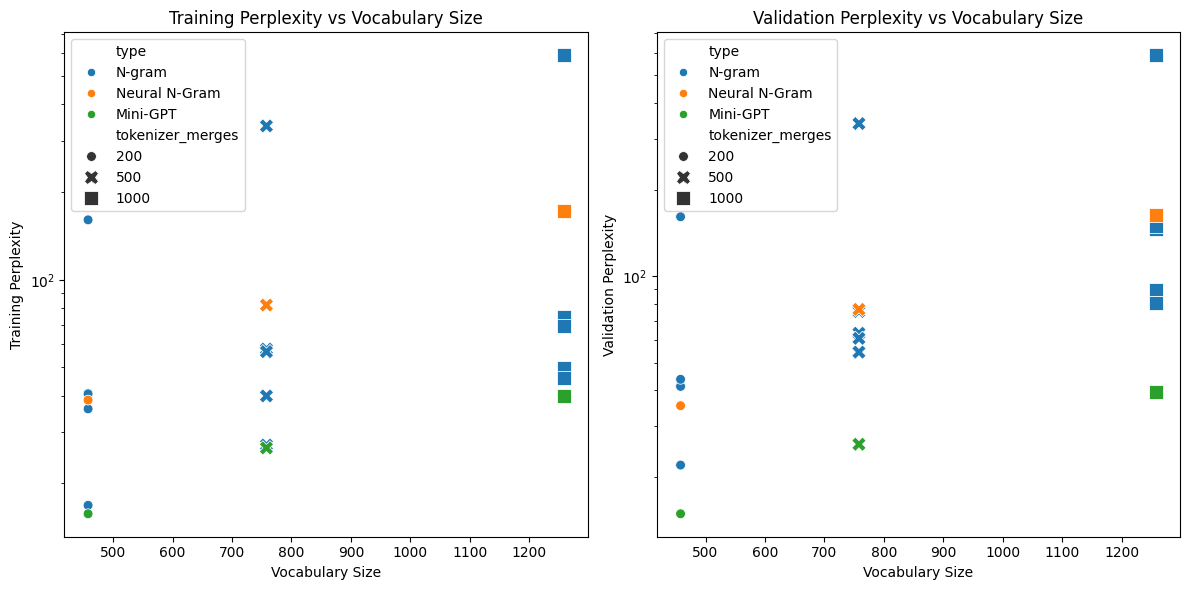

In [9]:
# results Visualization

# create figures directory if it doesn't exist
figures_dir = Path("../figures")
figures_dir.mkdir(exist_ok=True, parents=True)

# plot perplexity comparison with tokenizer info
plt.figure(figsize=(16, 8))

# training perplexity
plt.subplot(1, 2, 1)
sns.barplot(x='config', y='train_ppl', hue='tokenizer_merges', data=all_results_df)
plt.title('Training Perplexity by Tokenizer')
plt.xlabel('Model Configuration')
plt.ylabel('Perplexity (lower is better)')
plt.yscale('log')
plt.xticks(rotation=45)
plt.legend(title='Tokenizer Merges')
plt.tight_layout()

# validation perplexity
plt.subplot(1, 2, 2)
sns.barplot(x='config', y='val_ppl', hue='tokenizer_merges', data=all_results_df)
plt.title('Validation Perplexity by Tokenizer')
plt.xlabel('Model Configuration')
plt.ylabel('Perplexity (lower is better)')
plt.yscale('log')
plt.xticks(rotation=45)
plt.legend(title='Tokenizer Merges')
plt.tight_layout()

plt.savefig("../figures/perplexity_by_tokenizer_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# plot training time comparison
plt.figure(figsize=(14, 6))
sns.barplot(x='config', y='train_time', hue='tokenizer_merges', data=all_results_df)
plt.title('Training Time Comparison by Tokenizer')
plt.xlabel('Model Configuration')
plt.ylabel('Training Time (seconds)')
plt.xticks(rotation=45)
plt.legend(title='Tokenizer Merges')
plt.tight_layout()
plt.savefig("../figures/training_time_by_tokenizer_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# create a vocabulary size vs perplexity plot
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x='vocab_size', y='train_ppl', hue='type', style='tokenizer_merges', 
                size='tokenizer_merges', sizes=(50, 200), data=all_results_df)
plt.title('Training Perplexity vs Vocabulary Size')
plt.xlabel('Vocabulary Size')
plt.ylabel('Training Perplexity')
plt.yscale('log')

plt.subplot(1, 2, 2)
sns.scatterplot(x='vocab_size', y='val_ppl', hue='type', style='tokenizer_merges',
                size='tokenizer_merges', sizes=(50, 200), data=all_results_df)
plt.title('Validation Perplexity vs Vocabulary Size')
plt.xlabel('Vocabulary Size')
plt.ylabel('Validation Perplexity')
plt.yscale('log')

plt.tight_layout()
plt.savefig("../figures/perplexity_vs_vocab_size.png", dpi=300, bbox_inches='tight')
plt.show()

## Text Generation Comparison

Compare text generation quality between models.

In [10]:
# display generated samples side by side
samples_df = all_results_df[['type', 'config', 'sample']]
samples_df = samples_df.sort_values(['type', 'config'])

print("Generated Text Samples:")
for _, row in samples_df.iterrows():
    print(f"\n{row['type']} - {row['config']}:")
    print(f"  \"{row['sample']}\"")

# create a more structured table view
html_table = "<table><tr><th>Model Type</th><th>Configuration</th><th>Generated Text</th></tr>"
for _, row in samples_df.iterrows():
    html_table += f"<tr><td>{row['type']}</td><td>{row['config']}</td><td>{row['sample']}</td></tr>"
html_table += "</table>"

from IPython.display import HTML
display(HTML(html_table))

Generated Text Samples:

Mini-GPT - tiny (emb=64, layers=4):
  "thee with him speak with my heart. bassanio. well, my lord; but "

Mini-GPT - tiny (emb=64, layers=4):
  "thee. talk sisters. pray you heaven, lady, for the courtesy- rather"

Mini-GPT - tiny (emb=64, layers=4):
  "thee, my wit hath cow'd my hand, to bid thee beheld the pale home. hor. ay, my lord"

N-gram - 1-gram (laplace):
  "the., im phalllowillas ; and  yourit y.  youcauram my his , ce yourrot. ou5oreres"

N-gram - 1-gram (laplace):
  "thewith mane?n thanroder as hat 1 manthe redy s. guestut %ence n do whiser shallgoranind s"

N-gram - 1-gram (laplace):
  "the tw, that 'llhvan them she  like are  thee s to orn ace.  tonighsing, i had we  say fearsay make  it  as chillove ep"

N-gram - 2-gram (backoff):
  "thee here-wiffrom the works hapermishopaber lation in per w"

N-gram - 2-gram (backoff):
  "thee, dst a knot best lasoughter. i am at of five, unish'azo. he "

N-gram - 2-gram (backoff):
  "thee, hapt have i pand; an

Model Type,Configuration,Generated Text
Mini-GPT,"tiny (emb=64, layers=4)","thee with him speak with my heart. bassanio. well, my lord; but"
Mini-GPT,"tiny (emb=64, layers=4)","thee. talk sisters. pray you heaven, lady, for the courtesy- rather"
Mini-GPT,"tiny (emb=64, layers=4)","thee, my wit hath cow'd my hand, to bid thee beheld the pale home. hor. ay, my lord"
N-gram,1-gram (laplace),"the., im phalllowillas ; and yourit y. youcauram my his , ce yourrot. ou5oreres"
N-gram,1-gram (laplace),thewith mane?n thanroder as hat 1 manthe redy s. guestut %ence n do whiser shallgoranind s
N-gram,1-gram (laplace),"the tw, that 'llhvan them she like are thee s to orn ace. tonighsing, i had we say fearsay make it as chillove ep"
N-gram,2-gram (backoff),thee here-wiffrom the works hapermishopaber lation in per w
N-gram,2-gram (backoff),"thee, dst a knot best lasoughter. i am at of five, unish'azo. he"
N-gram,2-gram (backoff),"thee, hapt have i pand; and in to n but i will not come hemy, my move; iago. that used commerci"
N-gram,2-gram (laplace),thee well aberef. acliack bes. idyer for the a so you our


# Conclusion

During this experiment we took a look on three language modeling approaches: classical N-gram models, neural N-gram models, and transformer-based Mini-GPT architectures. We conducted a systematical comparison of these models across multiple BPE tokenization strategies, andf found several important insights about the fundamental trade offs in language modeling.

## Key Quantitative Findings

| Model Type | Best Tokenizer | Best Val. Perplexity | Training Time | Memory Usage |
|------------|----------------|----------------------|---------------|--------------|
| N-gram (3-gram w/interpolation) | 200 merges | 21.99 | <1 second | Minimal |
| Neural N-gram | 200 merges | 35.95 | 880 seconds | Moderate |
| Mini-GPT | 200 merges | 15.33 | 4300 seconds | High |

The Mini-GPT architecture achieved the lowest perplexity scores, but at approximately 4000x the computational cost of classical N-gram models. 

## Tokenizer Impact and Vocabulary Size

The findings regarding tokenizer vocabulary size were counterintuitive: **smaller vocabularies consistently outperformed larger ones across all model architectures**. The 200-merge tokenizer (smallest vocabulary) produced the best results for every model type, with performance degrading as vocabulary size increased:

- The 200-merge tokenizer outperformed the 500-merge by 36% and the 1000-merge by 57% in N-gram models
- Similar patterns appeared in neural models, demonstrating this is a fundamental pattern rather than model-specific

This contradicts the common assumption that larger vocabularies capture more linguistic patterns and highlights the importance of finding the optimal vocabulary size for the specific dataset and task.

## Unicode Errors as Valuable Insights

The Unicode decode errors took place predominantly with larger vocabularies (500+ merges) in N-gram models revealing a fundamental limitation: with the growth of vocabulary size, the probability space becomes more sparse, leading to statistically valid but linguistically invalid token combinations. This phenomenon demonstrates why modern language models carefully balance vocabulary size against statistical reliability.

These errors weren't implementation bugs, but rather an emergent property that helps explain why smaller vocabularies performed better, as they maintain a more statistically robust token distribution that's less prone to generating invalid sequences.

## Trade-offs Between Model Architectures

Our experiments revealed clear trade-offs between the different approaches:

1. **Classical N-grams**: Extremely fast training (0.5 seconds), reasonable perplexity (21.99), and minimal resource requirements make them surprisingly competitive for simple language tasks, especially with advanced smoothing techniques like interpolation.

2. **Neural N-grams**: Moderate training time (880 seconds) with slightly improved modeling capacity, but the performance gains didn't justify the significantly higher computational cost compared to classical N-grams.

3. **Mini-GPT**: Best modeling capacity with lowest perplexity (15.33), but at enormous computational cost (4300 seconds training time) - approximately 4000x slower than classical N-grams.

The performance-to-computational-cost ratio suggests that classical N-gram models remain valuable in resource-constrained environments, while Mini-GPT's superior modeling capabilities are better suited for quality-focused applications with abundant computing resources.

## Text Generation Quality and Model Evaluation

As we found out by analysing generated text, perplexity metrics don't always correlate with perceived text quality. Some models with higher perplexity occasionally generated more coherent or linguistically plausible text, highlighting the importance of supplementing quantitative metrics with qualitative evaluation.

This inconsistent between perplexity and generation quality is a known issue in the field of language modeling  and gives us a reminderthat optimizing for a single metric (perplexity) doesn't necessarily guarantee improvements in all aspects of language model performance.


These findings align with observations in larger language models, where tokenization strategy significantly impacts performance. Our discovery that smaller vocabularies outperformed larger ones reflects the importance of data-specific tokenization optimization even in billion-parameter models.